## QBIO499 Assignment 10
### Due Friday, May 3rd before midnight (California time)

In this assignment, you will explore neural network architectures by working with a denoising autoencoder developed using TensorFlow and Keras, and the MNIST dataset. The main objective is to understand how an autoencoder is used for image denoising and to experiment with extending this model to simulate diffusion model processes.

Denoising is a key application of deep learning aimed at cleaning corrupted images to recover their original form. This is crucial in fields like medical imaging, digital forensics, and photography. Denoising autoencoders, which reconstruct a clean image from a noisy one, are particularly suited for this task

Diffusion models, which are sophisticated generative models that model data distributions by progressively adding and removing noise, provide a framework for extending autoencoders to simulate diffusion processes. This not only helps understand the mechanics of both models but also allows for the exploration of new hybrid approaches combining their strengths.

In [1]:
# Initialize
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Activation
import matplotlib.pyplot as plt

In [2]:
# Load MNIST data
(x_train, _), (x_test, _) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize images

# Reshape the data to include channel dimension
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
# Function to add noise with gradually increasing intensity
def add_noise(images, noise_factor=0.5, step=0, max_steps=50):
    if max_steps == 1:
        current_noise_factor = noise_factor
    else:
        current_noise_factor = noise_factor * (step / max_steps)

    print(f"Current noise factor:{current_noise_factor}")
    
    noisy_images = images + current_noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

**Q1: Describe the function and role of the add_noise function in the context of simulating a diffusion process. How does changing the `noise_factor` and `max_steps` parameters affect the model's training and performance? [1pt]**

The add_noise function injects noise into the data inputs to the model in order to train the generative model. The diffusion process consists of adding noise to the data in progressive steps (forward diffusion process) and then training the model to denoise the data into something which aligns with the initial input sample population (reverse diffusion process). The noise_factor parameter represents the maximum intensity of the noise to be injected into the data. Increasing this value may enhance the model performance if the diffusion process is successful, but it may also overwhelm the model and result in poor outcomes. The max_steps parameter represents the maximum number of steps in the diffusion process, which determines the increments in which the noise is increased. For instance, if the noise_factor is 0.5 and the max_steps is 5, then the noise in each step will likely increase in increments of 0.1 until the final step where we achieve the maximum noise factor of 0.5. Adding more steps to the model could enhance it by alloting the model more time steps to denoise the data, but it could also hinder it if the model still cannot denoise the data or if it becomes fixated on the noise and actually deteriorates in performance over time. 

In [4]:
# Define the model using the functional API
def build_model():
    inputs = Input(shape=(28, 28, 1))
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(32, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

**Q2: Explain the architecture of the denoising autoencoder used above. Identify the roles of convolutional layers and convolutional transpose layers in the context of denoising. [1pt]**

The denoising autoencoder is principally composed of two Conv2D (convolutional) layers followed by two Conv2DTranspose (convolutional transpose) layers. The convolutional layers are responsible for deconstructing the input data into condensed hierarchical representations of the data while minimizing the influence of noise. The convolutional transpose layers are responsible for reconstructing the input data using the encoded representation outputted by the convolutional layer. With regards to denoising, the convolutional layer can be viewed as the layer which learns the patterns within the inputted noisy data and the transpose layer can be viewed as the layer which uses the learned features to reconstruct a more clear and denoised version of the input. This architecture also implements batch normalization layers which normalize the activations and enhance the model's approach towards convergence. The ReLU activation layers help introduce nonlinearity and address the potential issue of vanishing gradients.  

In [5]:
# Function to display images
def display_images(noisy, original, denoised):
    n = 10  # How many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display noisy images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(noisy[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display original images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display denoised images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(denoised[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Current noise factor:0.0
188/188 [==============================] - 7s 34ms/step - loss: 0.1167 - val_loss: 0.2359
Current noise factor:0.08000000000000002
188/188 [==============================] - 6s 32ms/step - loss: 0.0660 - val_loss: 0.0826
Current noise factor:0.16000000000000003
188/188 [==============================] - 6s 32ms/step - loss: 0.0675 - val_loss: 0.0690
Current noise factor:0.24
188/188 [==============================] - 6s 32ms/step - loss: 0.0719 - val_loss: 0.0718
Current noise factor:0.32000000000000006
188/188 [==============================] - 6s 32ms/step - loss: 0.0776 - val_loss: 0.0774
Current noise factor:0.4
188/188 [==============================] - 6s 32ms/step - loss: 0.0849 - val_loss: 0.0870
Current noise factor:0.48
188/188 [==============================] - 6s 33ms/step - loss: 0.0939 - val_loss: 0.0958
Current noise factor:0.5599999999999999
188/188 [==============================] - 6s 33ms/step - loss: 0.1046 - val_loss: 0.1043
Current noise f

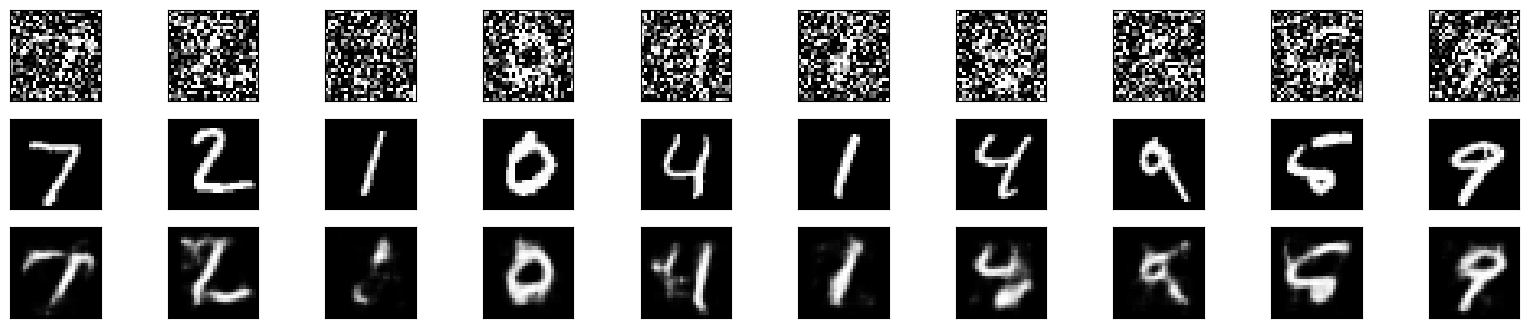

In [10]:
model = build_model()
model.compile(optimizer='adam', loss='binary_crossentropy')
#model.summary()

# Incremental training to simulate diffusion process
max_steps = 10
noise_factor = 0.8
history = []
for step in range(max_steps):
    noisy_train = add_noise(x_train, noise_factor=noise_factor, step=step, max_steps=max_steps)
    step = model.fit(noisy_train, x_train, epochs=1, batch_size=256, validation_split=0.2)
    history.append(step)

# Predicting on test set to visualize the denoising
noisy_test = add_noise(x_test, noise_factor=noise_factor, step=max_steps, max_steps=max_steps)
predicted = model.predict(noisy_test)

# Displaying images
display_images(noisy_test, x_test, predicted)

**Q3: How effective is the autoencoder at denoising images across different noise levels? Plot the validation loss from the training results and discuss what you find. [3pt]**

The autoencoder is most effective at denoising images at low to moderate noise levels, as evidenced by the minimum in validation loss achieved at a noise factor of 0.24. In the first few steps where the noise factor was below 0.24, we observe very high validation and training loss which may be a result of overfitting since the data is almost virtually noiseless. As a result, the model cannot extract general high-level features but rather hones in on the peculiarities of the training data, making it perform poorly when faced with a slighlty noisy test input. At the optimal noise factor of 0.24, the model is likely able to extract hierarchical features without being overfit because the added noise precludes it. Beyond the optimal noise factor, the noise may have become excessive and prevents the model from extracting more features because the validation loss begins to ascend. As a result, the model is not able to reconstruct a high-fidelity version of the input.

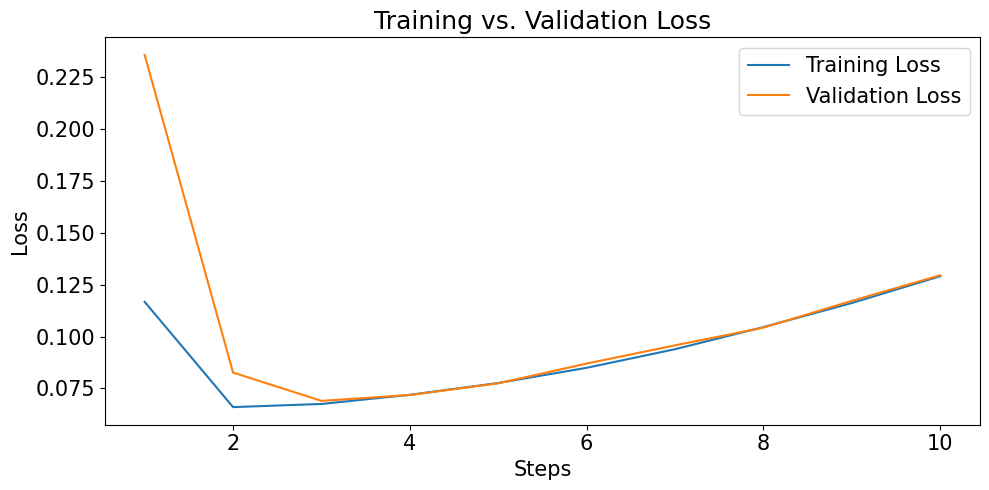

In [12]:
loss = [step.history['loss'][0] for step in history]
val_loss = [step.history['val_loss'][0] for step in history]
epoch = range(1, len(loss) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epoch, loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.title('Training vs. Validation Loss', fontsize=18)
plt.xlabel('Steps', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.tight_layout()
plt.show()

**Q4: After training the model with `max_steps` set to 1, 5, and 10, analyze the outputs. The max_steps=1 setting implies no incremental noise addition, whereas `max_steps=5` and `max_steps=10` introduce noise gradually over more steps. Compare the results from these settings and discuss how varying the number of steps affects the model's performance. Explain why gradually increasing the noise level during training, simulating multiple diffusion steps, might be beneficial. [3pt]**

The max_steps of 1 model shows relatively poor performance with a validation loss of 0.4885, indicating that more noise adding steps are likely required to allow for the convolutional layers to extract more features and for the transpose layers to accurately reconstruct the input. The max_steps of 5 model shows better performance (validation loss of 0.0803) with the most optimal performance at the third step with noise factor 0.48. Beyond the third step, the noise begins to hinder the model as the validation loss increases because the convolutional layers are likely not able to effectively extract higher order features with excess noise. The max_steps of 10 model from Q3 validates our belief that noise factor of around 0.25 achieved by a three-step diffusion process yields optimal perfomance as evidenced by a validation loss of 0.0690. The gradual increasing of noise during training during multiple diffusion steps might be beneficial because it allows the model more opportunities to extract higher order features. For instance, during the first step with minimal noise, the model may learn meta-level details since it has access to most of the data. During the next step with more noise, the model might focus in on different features and learn them because the noise redirects its attention. However, there needs to be a fine balance for the noise factor and number of steps because minimal or excess noise can result in poor learning by the model.

Current noise factor:0.0
188/188 [==============================] - 7s 34ms/step - loss: 0.1209 - val_loss: 0.1181
Current noise factor:0.16000000000000003
188/188 [==============================] - 6s 32ms/step - loss: 0.0719 - val_loss: 0.0860
Current noise factor:0.32000000000000006
188/188 [==============================] - 6s 32ms/step - loss: 0.0799 - val_loss: 0.0817
Current noise factor:0.48
188/188 [==============================] - 6s 32ms/step - loss: 0.0967 - val_loss: 0.0962
Current noise factor:0.6400000000000001
188/188 [==============================] - 6s 32ms/step - loss: 0.1201 - val_loss: 0.1212
Current noise factor:0.8
313/313 [==============================] - 2s 6ms/step


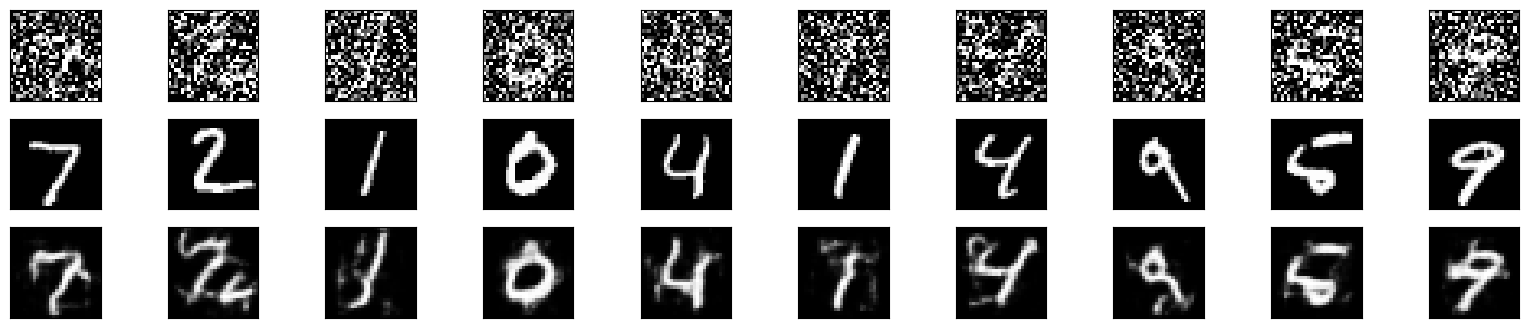

In [13]:
model = build_model()
model.compile(optimizer='adam', loss='binary_crossentropy')
#model.summary()

# Incremental training to simulate diffusion process
max_steps = 5
noise_factor = 0.8
history = []
for step in range(max_steps):
    noisy_train = add_noise(x_train, noise_factor=noise_factor, step=step, max_steps=max_steps)
    step = model.fit(noisy_train, x_train, epochs=1, batch_size=256, validation_split=0.2)
    history.append(step)
# Predicting on test set to visualize the denoising
noisy_test = add_noise(x_test, noise_factor=noise_factor, step=max_steps, max_steps=max_steps)
predicted = model.predict(noisy_test)

# Displaying images
display_images(noisy_test, x_test, predicted)

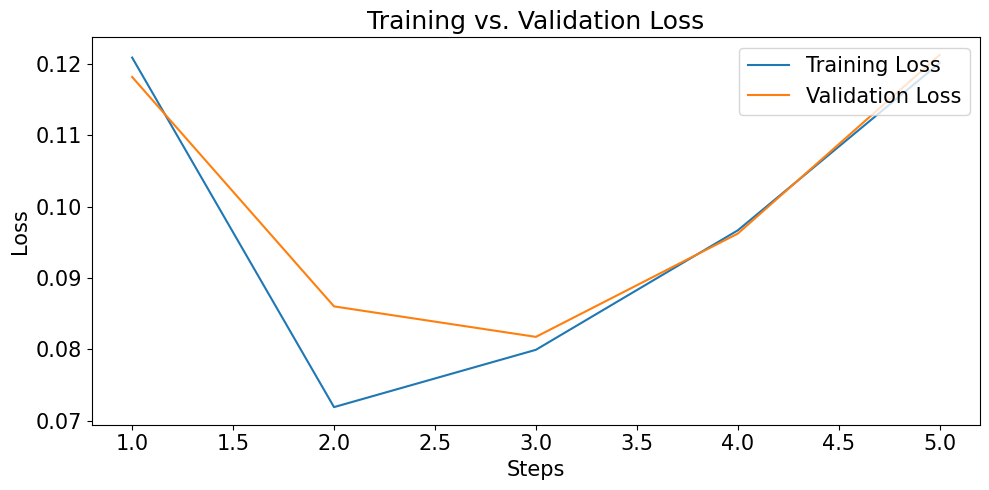

In [14]:
loss = [step.history['loss'][0] for step in history]
val_loss = [step.history['val_loss'][0] for step in history]
epoch = range(1, len(loss) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epoch, loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.title('Training vs. Validation Loss', fontsize=18)
plt.xlabel('Steps', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.tight_layout()
plt.show()

Current noise factor:0.8
188/188 [==============================] - 7s 33ms/step - loss: 0.2507 - val_loss: 0.4885
Current noise factor:0.8
313/313 [==============================] - 2s 6ms/step


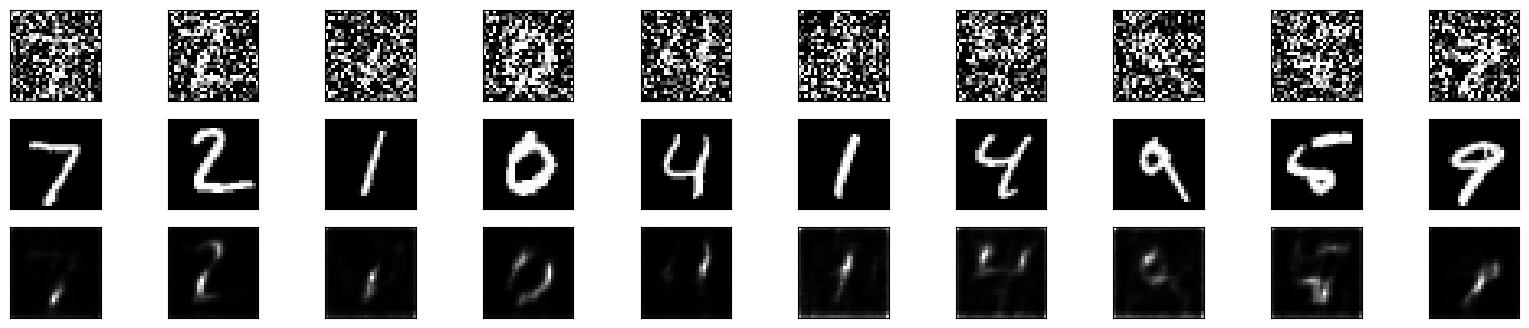

In [8]:
model = build_model()
model.compile(optimizer='adam', loss='binary_crossentropy')
#model.summary()

# Incremental training to simulate diffusion process
max_steps = 1
noise_factor = 0.8
for step in range(max_steps):
    noisy_train = add_noise(x_train, noise_factor=noise_factor, step=step, max_steps=max_steps)
    model.fit(noisy_train, x_train, epochs=1, batch_size=256, validation_split=0.2)
    
# Predicting on test set to visualize the denoising
noisy_test = add_noise(x_test, noise_factor=noise_factor, step=max_steps, max_steps=max_steps)
predicted = model.predict(noisy_test)

# Displaying images
display_images(noisy_test, x_test, predicted)